In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt



pd.set_option('display.max_columns', None)

imputedDataset = pd.read_stata("/Users/burke/Documents/research/bpCog/mcm/mcm/data/fullyImputedDataset.dta")
imputedDataset.head()

# Now the goal is to see what the risk factors would look like for the NHANES 1999 population, if we advanced them to 20110

For the NHANES side of things, we want the blood pressure distribution in 2011 that excludes people that moved into the coutnry in the prior 12 years (since 1999). 

For the simulation side of things, we'll need to load the mortality data so that we can take out the poeple that died between 1999 and 2011.



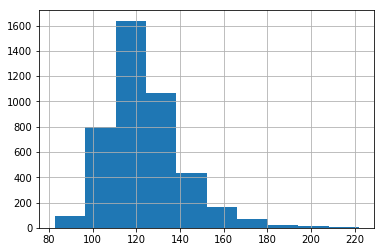

In [2]:
% matplotlib inline
noRecentUSInmigration = imputedDataset.loc[~imputedDataset.timeInUS.isin([1,2,3])]
recentCrossSectionOfNonImmigrants = noRecentUSInmigration.loc[noRecentUSInmigration.year==2011]
# the simulated cohort starts in 1999 and then ages people forward 11 years...so, teh youngest age is 29
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.loc[recentCrossSectionOfNonImmigrants.age > 18 +11]
recentCrossSectionOfNonImmigrants = recentCrossSectionOfNonImmigrants.sample(n=len(recentCrossSectionOfNonImmigrants), weights=recentCrossSectionOfNonImmigrants.WTINT2YR, replace=True)


recentCrossSectionOfNonImmigrants.meanSBP.hist()

In [3]:
earlyCrossSectionOfNonImmigrants = imputedDataset.loc[imputedDataset.year==2001]
# here we just need to throw out the very young people for comparisons
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.loc[earlyCrossSectionOfNonImmigrants.age > 18 + 2]
earlyCrossSectionOfNonImmigrants = earlyCrossSectionOfNonImmigrants.sample(n=len(earlyCrossSectionOfNonImmigrants), weights=earlyCrossSectionOfNonImmigrants.WTINT2YR, replace=True)

print (earlyCrossSectionOfNonImmigrants.meanSBP.describe())

count    5306.000000
mean      123.810906
std        19.912866
min        79.333333
25%       110.666667
50%       119.666667
75%       132.666667
max       229.333333
Name: meanSBP, dtype: float64


# Run a simple simulation with the cohort models (default) starting in 1999 as a comparator

In [4]:
import os
os.chdir("/Users/burke/Documents/research/bpCog/mcm")
from mcm.population import NHANESDirectSamplePopulation

pop = NHANESDirectSamplePopulation(n=5000, year=1999)
pop.advance(10)

sbps = pd.Series([ person._sbp[-1] for person in pop._people if not person.diedBy2011])


### Compare SBPs between teh simluation and between NHANES

NHANES SBPS
count    4297.000000
mean      123.453417
std        17.490342
min        82.666667
25%       112.000000
50%       121.333333
75%       132.000000
max       222.000000
Name: meanSBP, dtype: float64
Simulation SBPs
: count    4320.000000
mean      122.941438
std        16.517353
min        76.103112
25%       111.521914
50%       120.690094
75%       130.770003
max       219.960208
dtype: float64


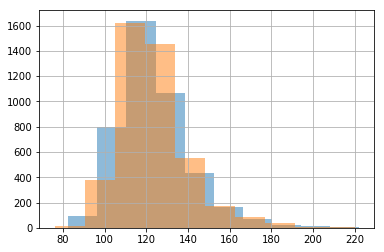

In [9]:
recentCrossSectionOfNonImmigrants.meanSBP.hist(alpha=0.5)
sbps.hist(alpha=0.5)
print ("NHANES SBPS\n" + str(recentCrossSectionOfNonImmigrants.meanSBP.describe()))
print("Simulation SBPs\n: " + str(sbps.describe()))

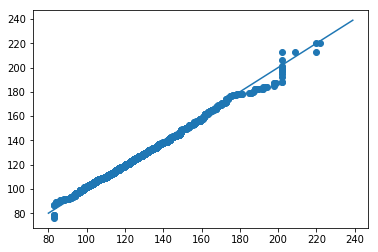

In [6]:
plt.scatter(recentCrossSectionOfNonImmigrants.meanSBP.sort_values(), 
     sbps.sample(n=len(recentCrossSectionOfNonImmigrants)).sort_values())

plt.plot(np.arange(80,240), np.arange(80, 240))

Summary — SBP pressure predictions afgter 11 years look quite good. Mean is very close to the NHANES mean, variance is slightly reduced and there is slight underprediction on trhe very high end, but its not awful.

In fact, I think its close enough that I wouldn't recalibrate. Instead, I think we can see how we do when we add treatmetn...and if it holds up ok, then I think we're done and won't need recalibration.

meanSBP


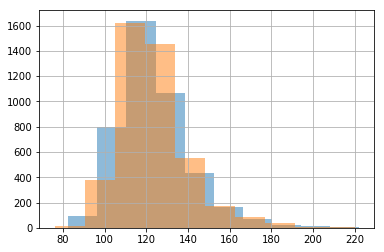

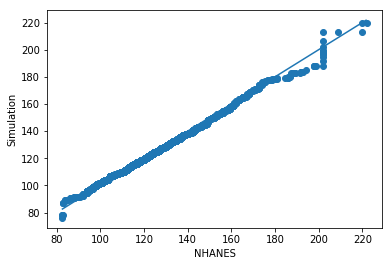

meanDBP


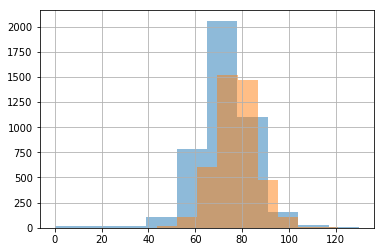

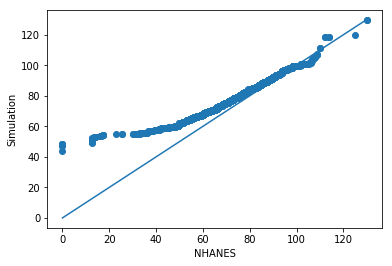

bmi


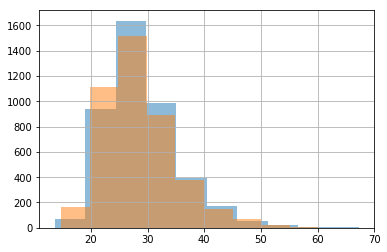

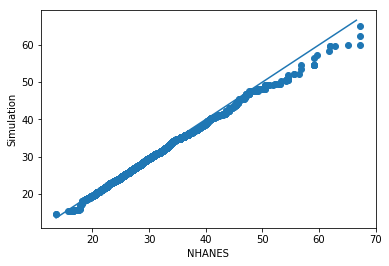

ldl


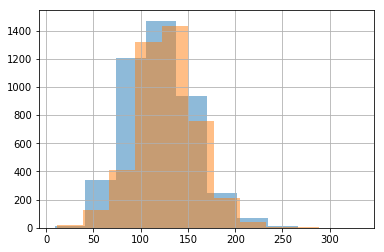

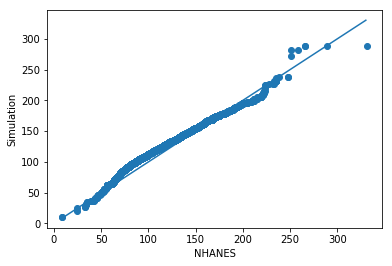

hdl


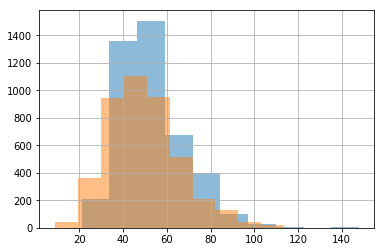

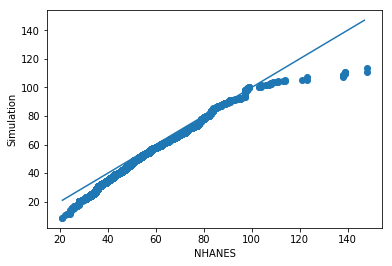

a1c


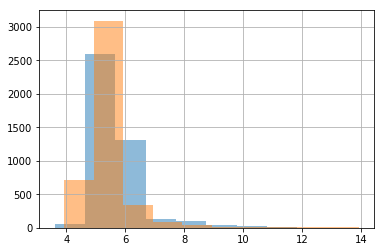

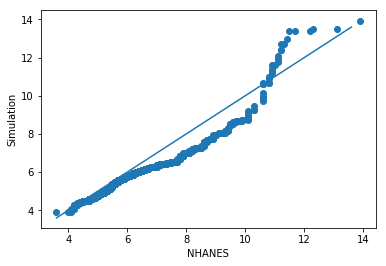

trig


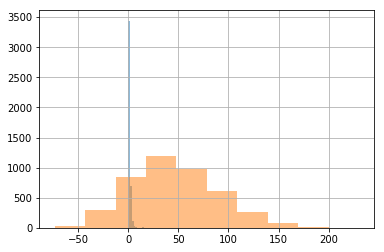

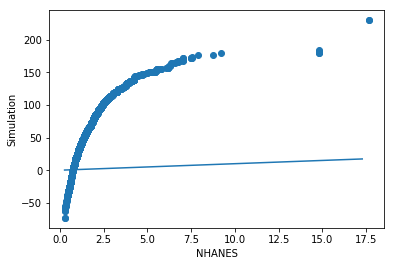

In [19]:
riskFactors = [("meanSBP", "sbp"), ("meanDBP", "dbp"), ("bmi", "bmi"), ("ldl", "ldl"), ("hdl", "hdl"), ("a1c", "a1c"), ("trig", "trig")]

def getRiskFactors(nhanesName, simName):
    nhanes = recentCrossSectionOfNonImmigrants[nhanesName]
    sim = [ getattr(person, "_" + simName)[-1] for person in pop._people if not person.diedBy2011]
    return (nhanes, pd.Series(sim))
    
for riskFactorTuple in riskFactors:
    print(riskFactorTuple[0])
    nhanes, sim = getRiskFactors(riskFactorTuple[0], riskFactorTuple[1])
    nhanes.hist(alpha=0.5)
    sim.hist(alpha=0.5)
    plt.show()
    
    plt.scatter(nhanes.sort_values(), 
     sim.sample(n=len(recentCrossSectionOfNonImmigrants)).sort_values())
    plt.plot(np.arange(nhanes.min(),nhanes.max()), np.arange(nhanes.min(), nhanes.max()))
    plt.xlabel("NHANES")
    plt.ylabel("Simulation")
    plt.show()
